# Tutorial 3-2: The Great Optimizer Race

**Course:** CSEN 342: Deep Learning  
**Topic:** Optimization Algorithms (SGD, Momentum, Adam, AdamW) and Schedulers

## Objective
In the lecture, we discussed how standard **Gradient Descent** can get stuck in local minima or oscillate in ravines. We introduced advanced optimizers like **Momentum**, **RMSProp**, and **Adam** designed to overcome these issues.

In this tutorial, we will:
1.  **Visualize the Landscape:** Define a tricky 2D loss function (the **Beale Function**) that mimics the difficult terrain of high-dimensional loss surfaces. It has large flat regions where gradients are tiny and sharp peaks.
2.  **Run the Race:** Compare the trajectories of SGD, Momentum, Adam, and the modern standard **AdamW**. We will measure not just *if* they converge, but *how fast* (in steps) they reach the minimum.
3.  **Tune the Schedule:** Compare **Step Decay** vs. **Cosine Annealing**. 

---

## Part 1: The Loss Landscape

We use the **Beale Function**, a classic benchmark for optimization algorithms. 
$$ f(x, y) = (1.5 - x + xy)^2 + (2.25 - x + xy^2)^2 + (2.625 - x + xy^3)^2 $$

It has a global minimum at $(3, 0.5)$. The challenge is that the gradient in the flat regions is very small, making it hard for standard SGD to make progress.

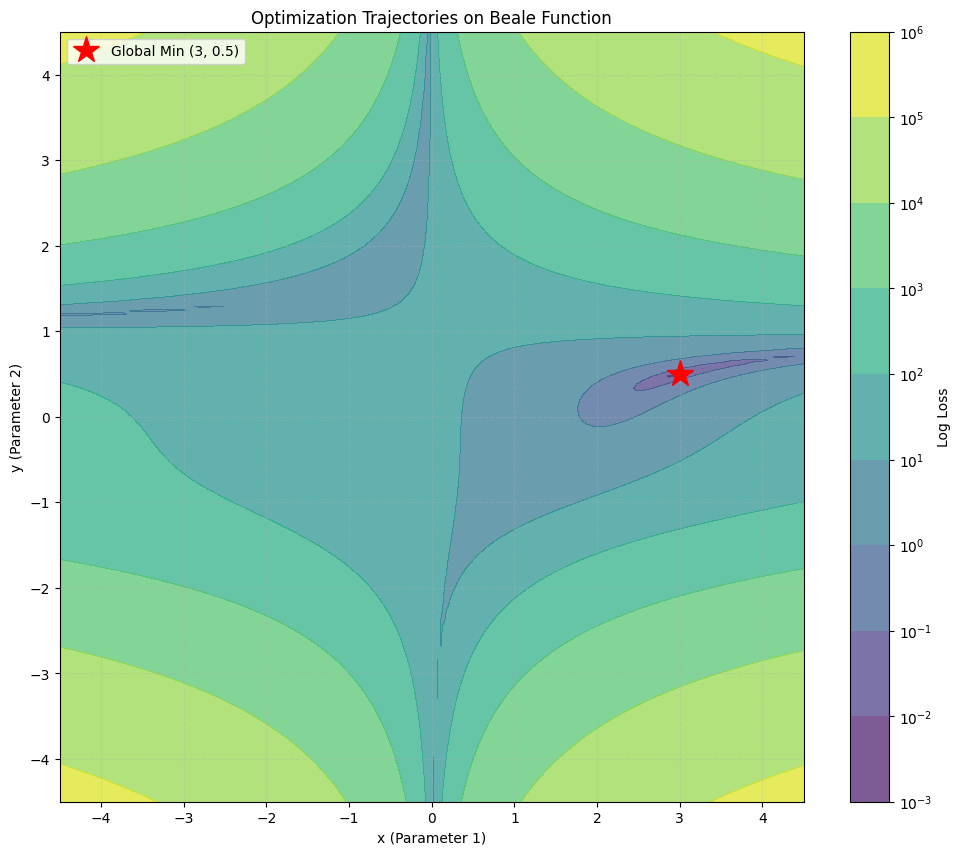

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Define the Beale Function using PyTorch tensors
def beale(x, y):
    return (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

# Visualization Utility
def plot_surface(paths=None, names=None):
    # Generate grid for plotting
    x = np.linspace(-4.5, 4.5, 200)
    y = np.linspace(-4.5, 4.5, 200)
    X, Y = np.meshgrid(x, y)
    Z = beale(X, Y)

    plt.figure(figsize=(12, 10))
    
    # Log scale contour plot to see the minima better
    plt.contourf(X, Y, Z, levels=50, norm=LogNorm(), cmap='viridis', alpha=0.7)
    plt.colorbar(label='Log Loss')
    
    # Plot the global minimum (known at x=3, y=0.5)
    plt.plot(3, 0.5, 'r*', markersize=20, label='Global Min (3, 0.5)', zorder=10)

    # Plot optimizer paths if provided
    if paths:
        # Distinct colors for tracks
        colors = ['white', 'cyan', 'magenta', 'orange']
        linestyles = ['-', '--', '-.', ':']
        
        for i, (path, name) in enumerate(zip(paths, names)):
            path = np.array(path)
            # zorder ensures tracks are drawn in order (later ones on top)
            plt.plot(path[:, 0], path[:, 1], color=colors[i % len(colors)], 
                     linestyle=linestyles[i % len(linestyles)],
                     linewidth=2, markersize=0, label=name, zorder=i+2, alpha=0.9)
            
            # Plot start and end points
            plt.plot(path[0, 0], path[0, 1], 'ko', markersize=5) # Start
            plt.plot(path[-1, 0], path[-1, 1], 'x', color=colors[i], markersize=10, markeredgewidth=2) # End
    
    plt.xlabel('x (Parameter 1)')
    plt.ylabel('y (Parameter 2)')
    plt.title('Optimization Trajectories on Beale Function')
    plt.legend(loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.xlim(-4.5, 4.5)
    plt.ylim(-4.5, 4.5)
    plt.show()

# Visualize the empty landscape
plot_surface()

---

## Part 2: The Race (Comparing Optimizers)

We will run different PyTorch optimizers starting from the same difficult point $(-3, -3)$ and see how they navigate towards the star (minimum).

### Why add AdamW?
Although your lecture slides cover Adam, modern deep learning research (specifically for Transformers like BERT and GPT) has largely shifted to **AdamW**.

**The difference:** Standard Adam implements L2 regularization by adding it to the loss function. AdamW decouples the weight decay from the gradient update step. This subtle mathematical difference results in significantly better generalization performance for deep models. As a student of Deep Learning, it is critical to look beyond the textbook and stay updated with the latest research papers (like *Loshchilov & Hutter, ICLR 2019* which introduced AdamW).

We will compare:
1.  **SGD:** Standard Gradient Descent.
2.  **SGD + Momentum:** Adding velocity to power through flat regions.
3.  **Adam:** The standard adaptive optimizer.
4.  **AdamW:** The modern standard with decoupled weight decay.

In [2]:
def run_optimizer(optimizer_class, lr=0.01, steps=2000, gradient_clip=False, **kwargs):
    # 1. Initialize Parameters at a bad starting point (-3, -3)
    params = torch.tensor([-3.0, -3.0], requires_grad=True)
    
    # 2. Initialize the Optimizer
    optimizer = optimizer_class([params], lr=lr, **kwargs)
    
    path = []
    dist_to_target = []
    
    # Target location (Global Min)
    target = torch.tensor([3.0, 0.5])
    
    for i in range(steps):
        # Save current position
        current_pos = params.detach().numpy().copy()
        path.append(current_pos)
        
        # Calculate distance to target for analysis
        dist = torch.norm(params - target).item()
        dist_to_target.append(dist)
        
        # Optimization Step
        optimizer.zero_grad()
        loss = beale(params[0], params[1])
        loss.backward()

        # Clip gradients (if requested)
        if gradient_clip:
            torch.nn.utils.clip_grad_norm_([params], gradient_clip)
            
        optimizer.step()
        
        # Early stopping if we are extremely close
        if dist < 1e-3:
            break
            
    return path, dist_to_target

print("Optimization Harness Ready.")

Optimization Harness Ready.


### 2.1 Running the Race
* **SGD** usually needs a very high learning rate to move anywhere on this surface, or it gets stuck. We will give it `lr=0.01`.
* **Adam/AdamW** are adaptive, so they can handle `lr=0.1` effectively here.

Running optimizers... this may take a moment.


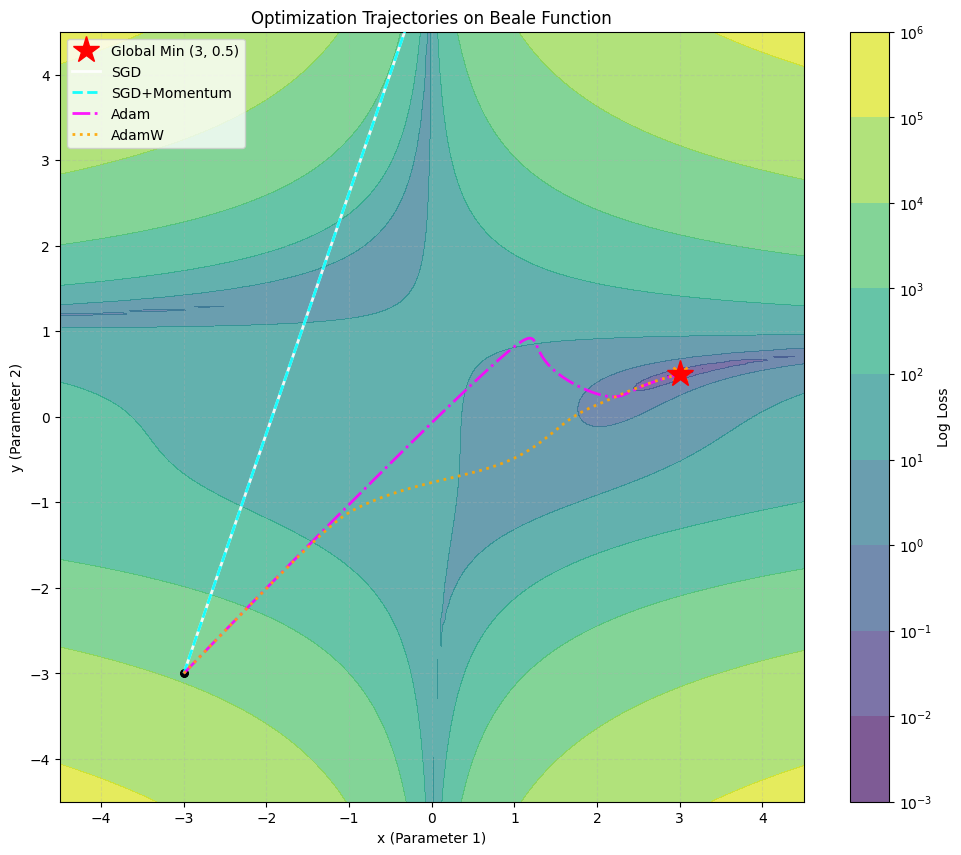

In [3]:
# Run the racers
print("Running optimizers... this may take a moment.")

# SGD often needs momentum to move in flat regions
path_sgd, dist_sgd = run_optimizer(torch.optim.SGD, lr=0.01, steps=25000)
path_mom, dist_mom = run_optimizer(torch.optim.SGD, lr=0.001, steps=25000, momentum=0.9)
path_adam, dist_adam = run_optimizer(torch.optim.Adam, lr=0.5, steps=25000)
path_adamw, dist_adamw = run_optimizer(torch.optim.AdamW, lr=0.1, steps=25000)

# Visualize Paths
plot_surface(
    paths=[path_sgd, path_mom, path_adam, path_adamw],
    names=['SGD', 'SGD+Momentum', 'Adam', 'AdamW']
)

### 2.2 Quantitative Analysis
Visuals are great, but numbers tell the truth. Let's see how many steps it took to reach the target (or how close they got).

In [4]:
def print_stats(name, path, dists):
    final_dist = dists[-1]
    steps = len(path)
    status = "Converged" if final_dist < 1e-2 else "Did not converge"
    print(f"{name:<15} | Steps: {steps:<5} | Final Dist: {final_dist:.4f} | Status: {status}")

print("Race Results (Target: Distance < 0.01):")
print("-"*65)
print_stats("SGD", path_sgd, dist_sgd)
print_stats("SGD+Momentum", path_mom, dist_mom)
print_stats("Adam", path_adam, dist_adam)
print_stats("AdamW", path_adamw, dist_adamw)

Race Results (Target: Distance < 0.01):
-----------------------------------------------------------------
SGD             | Steps: 25000 | Final Dist: nan | Status: Did not converge
SGD+Momentum    | Steps: 25000 | Final Dist: nan | Status: Did not converge
Adam            | Steps: 3307  | Final Dist: 0.0010 | Status: Converged
AdamW           | Steps: 17581 | Final Dist: 0.0004 | Status: Converged


### Discussion
You likely observed that **SGD** and **SGD+Momentum** failed to converge. The fact that your final distance is `nan` (Not a Number) means the optimization didn't just get "stuck"—it exploded. The parameters shot off to infinity.

The Beale function is deceptive. While it has a large flat plateau, it also has extremely steep "walls" or cliffs at the edges of the domain.
- **What happened:** Your SGD optimizer likely wandered into one of these steep regions. The gradient there was massive. Because SGD blindly multiplies the gradient by the learning rate ($w \leftarrow w - \eta \nabla L$), it took a gigantic step, landing in a spot with an even larger gradient (or infinity), causing the values to become `nan`.
- **Why Adam survived:** Adam divides the update by the square root of the running variance of the gradients ($v_t$). When gradients get huge, $v_t$ gets huge, effectively scaling down the step size and preventing the explosion.

*How do we fix SGD?*

We have two options:

1. **Lower the learning rate.** This is a simple fix but doesn't always work. SGD is extremely sensitive to the learning rate. 0.01 is too aggressive for the steep parts of this specific landscape. We can try lowering it by an order of magnitude. Note that, with a lower LR, SGD will move very slowly on the flat plateau, so it might still fail to reach the target in 25,000 steps.
2. **Gradient clipping.** This is a standard technique in training RNNs and deep networks (falls in the category of `optimization tricks`). It caps the maximum size of the gradient update, preventing explosions while allowing you to keep a higher learning rate.

Let's give it a try:

Running optimizers... this may take a moment.


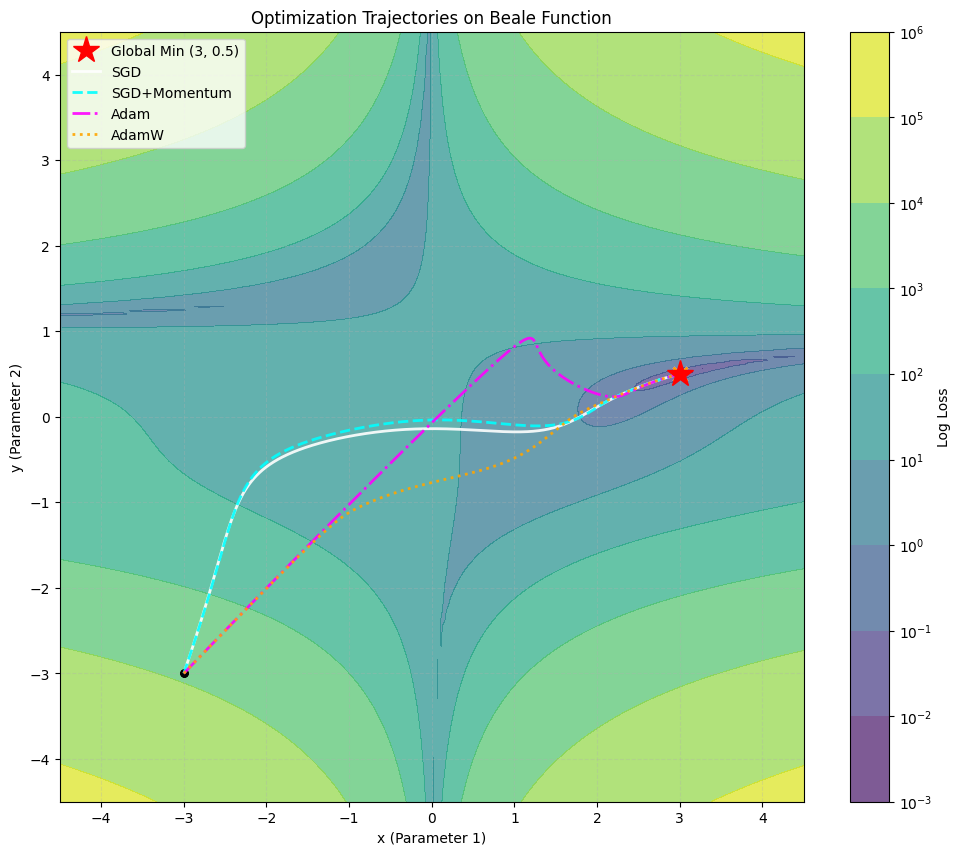

In [5]:
# Run the racers
print("Running optimizers... this may take a moment.")

# SGD often needs momentum to move in flat regions
path_sgd, dist_sgd = run_optimizer(torch.optim.SGD, lr=0.01, steps=25000, gradient_clip=True)
path_mom, dist_mom = run_optimizer(torch.optim.SGD, lr=0.001, steps=25000, momentum=0.9, gradient_clip=True)
path_adam, dist_adam = run_optimizer(torch.optim.Adam, lr=0.5, steps=25000)
path_adamw, dist_adamw = run_optimizer(torch.optim.AdamW, lr=0.1, steps=25000)

# Visualize Paths
plot_surface(
    paths=[path_sgd, path_mom, path_adam, path_adamw],
    names=['SGD', 'SGD+Momentum', 'Adam', 'AdamW']
)

In [6]:
def print_stats(name, path, dists):
    final_dist = dists[-1]
    steps = len(path)
    status = "Converged" if final_dist < 1e-2 else "Did not converge"
    print(f"{name:<15} | Steps: {steps:<5} | Final Dist: {final_dist:.4f} | Status: {status}")

print("Race Results (Target: Distance < 0.01):")
print("-"*65)
print_stats("SGD", path_sgd, dist_sgd)
print_stats("SGD+Momentum", path_mom, dist_mom)
print_stats("Adam", path_adam, dist_adam)
print_stats("AdamW", path_adamw, dist_adamw)

Race Results (Target: Distance < 0.01):
-----------------------------------------------------------------
SGD             | Steps: 2608  | Final Dist: 0.0010 | Status: Converged
SGD+Momentum    | Steps: 2544  | Final Dist: 0.0010 | Status: Converged
Adam            | Steps: 3307  | Final Dist: 0.0010 | Status: Converged
AdamW           | Steps: 17581 | Final Dist: 0.0004 | Status: Converged


### Conclusions

**SGD** sometimes gets stuck in the flat plateau because the gradient is too small to push it forward. However, a high learning rate can easily make the gradients explode. Gradient clipping can come to its rescue.

**Momentum**  helps carry the optimizer through the flat region using velocity. However, if the learning rate is too high, even when clipping gradients, momentum can spiral and overshoot the target. It accelerates down the steep cliffs, and by the time it reaches the minimum, it's moving so fast it flies right past it. It then tries to turn around, builds up speed again, and oscillates or diverges. Try running it with `lr=0.1` and see what happens.

**Adam** normalizes the update by the variance (second moment). It is like a "cautious driver." On the steep cliffs of the Beale function, the variance ($v_t$) becomes huge. Adam sees this high variance and drastically scales down the step size to prevent explosion. It is being "safe."

**AdamW** applies Weight Decay (L2 Regularization). Why was it the slowest? Weight decay pushes parameters toward zero (0, 0). The global minimum is at (3, 0.5). AdamW is trying to move to 3, but weight decay is constantly pulling it back toward 0. It's fighting a headwind!

For many Deep Learning problems, **Adam/AdamW** typically converge the fastest because they adapt the learning rate for each parameter individually. In some cases (like the Beal problem), you might find that SGD sometimes beats Adam in raw step count. This is because Adam is "safe"—it dampens the step size when gradients are steep to prevent explosion. However, notice that to make **SGD+Momentum** converge, we had to carefully tune (lower) the learning rate to 0.001. For Adam, we could aggressively raise it to 0.5 without diverging. **Adam's primary advantage is robustness**: it works reasonably well across a huge range of learning rates, whereas SGD requires precise tuning to avoid stalling or exploding. That is why it is preferred in most modern DL training.

---

## Part 3: Learning Rate Schedulers

In the lecture, we saw **Step Decay** (Slide 24). However, modern research often favors **Cosine Annealing**. The example below shows the effective learning rate across 50 epochs given the two chosen learning rate schedulers.

**Why Cosine Annealing?**
Step decay causes sudden "shocks" to the model training (the abrupt drops in loss seen in Slide 24). Cosine annealing lowers the learning rate smoothly, following a cosine curve. This ensures the model spends time exploring at all scales of learning rates, often finding better, flatter minima.

Simulating Schedules...


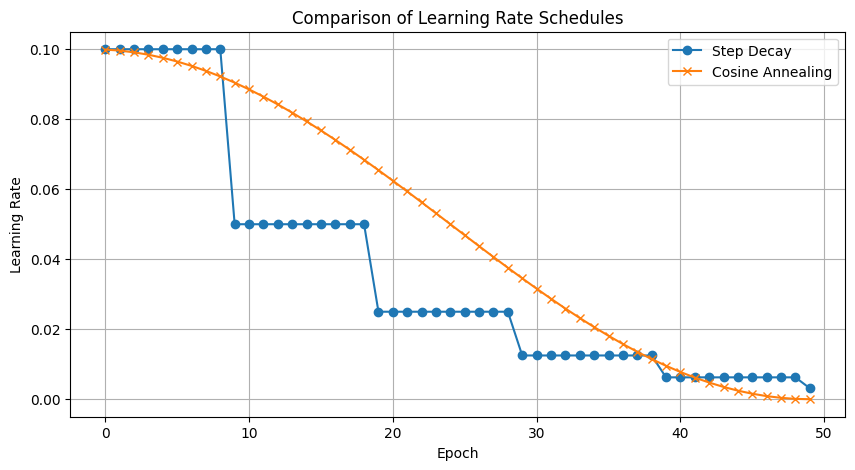

In [7]:
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Import utility functions
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
from utils import download_fashion_mnist

# Device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Load Data (Using ../data as requested)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
download_fashion_mnist()
trainset = torchvision.datasets.FashionMNIST(root='../data', train=True, download=False, transform=transform)
# Use a subset for speed
train_subset, _ = torch.utils.data.random_split(trainset, [5000, 55000])
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)

# 2. Define a Simple Model
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
).to(device)

# Helper to record LR changes
def simulate_schedule(scheduler_cls, steps=50, **kwargs):
    # Re-init optimizer for each run
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    scheduler = scheduler_cls(optimizer, **kwargs)
    lrs = []
    
    for _ in range(steps):
        # Mock Training Step
        optimizer.step()   # 1. Update weights first
        scheduler.step()   # 2. Update LR second (Fixes UserWarning)
        
        # Record LR
        lrs.append(optimizer.param_groups[0]['lr'])
        
    return lrs

print("Simulating Schedules...")

# 3. Run Simulations
# StepLR: Multiply LR by 0.5 every 10 epochs
lrs_step = simulate_schedule(optim.lr_scheduler.StepLR, step_size=10, gamma=0.5)

# Cosine: Smoothly decay from 0.1 to 0 over 50 epochs
lrs_cosine = simulate_schedule(optim.lr_scheduler.CosineAnnealingLR, T_max=50, eta_min=0)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(lrs_step, marker='o', label='Step Decay')
plt.plot(lrs_cosine, marker='x', label='Cosine Annealing')
plt.title("Comparison of Learning Rate Schedules")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.legend()
plt.grid(True)
plt.show()

### Conclusion
By visualizing the optimizers and schedulers, we can see why choices matter. While the lectures cover the foundational math, implementation details (like `AdamW` and step ordering) are critical for getting code to work in the real world.